# Keypoint extraction

Open a first image and find its characteristic keypoints.


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(975, 1300, 3) uint8


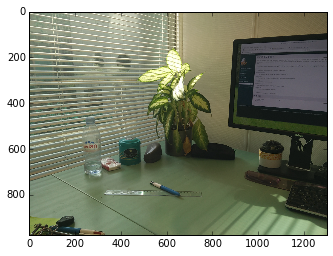

In [2]:
import fabio
image1 = fabio.open("IMG_20161103_114423.tiff").data
imshow(image1)
print(image1.shape, image1.dtype)  # RGB image: 975, 1300, 3 dtype:uint8

In the following code, replace "CPU" with "GPU" to test parallel computing on your graphics card.

In [3]:
from silx.image import sift
%time sift_ocl = sift.SiftPlan(template=image1, devicetype="CPU") 

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 14.3 ms


/usr/lib/python3/dist-packages/pyopencl/__init__.py:61: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Print information about the keypoints:


In [4]:
#print("Time for calculating the keypoints on one image of size %sx%s" % image1.shape)
%time keypoints = sift_ocl(image1)
print("Number of keypoints: %s" % len(keypoints))
print("Keypoint content:")
print(keypoints.dtype)
print("x: %.3f \t y: %.3f \t sigma: %.3f \t angle: %.3f" %
      (keypoints[-1].x,keypoints[-1].y, 
       keypoints[-1].scale,
       keypoints[-1].angle))
print("descriptor:")
print(keypoints[-1].desc)

CPU times: user 4.76 s, sys: 92 ms, total: 4.85 s
Wall time: 762 ms
Number of keypoints: 1159
Keypoint content:
[('x', '<f4'), ('y', '<f4'), ('scale', '<f4'), ('angle', '<f4'), ('desc', 'u1', (128,))]
x: 659.330 	 y: 567.805 	 sigma: 109.469 	 angle: -2.106
descriptor:
[  0   0   0   0   0   0   0   0   2   2   2   0   0   9  37   6  22   9
   3   0   0   4  26  29   4  28  14   1   0   0   0   0   0   0   0   0
  10  21   4   0  13   2   0   0  16 133 104  25 133  53   1   0   0  23
  57 107  55 133  39   1   0   0   0   4   0   0   0   0  11 133  83   2
  57  17   0   0  19 133  63  42 133  84   0   0   0   6   7 133  73  57
   2   0   0   0  19  74   4   2   0   0   0  45  32   3  48  74   5   0
   0  10  22  28 133  38   7   0   0   0   1 133  31   0   0   0   0   0
   8  82]


Display keypoints on the image:

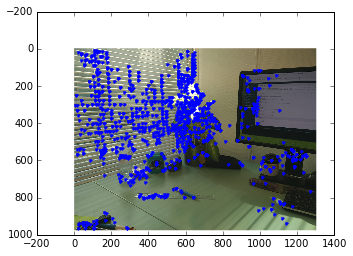

In [5]:
imshow(image1, cmap="gray")
plot(keypoints[:].x, keypoints[:].y,".")

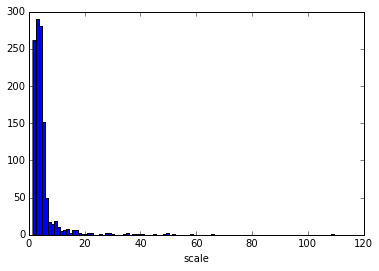

In [6]:
# Diplaying keypoints histogram by scale:
hist(keypoints[:].scale, 100)
xlabel("scale")

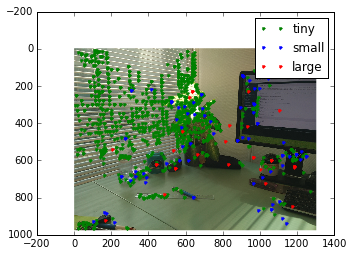

In [7]:
#One can see 3 groups of keypoints, boundaries at: 8 and 20. Let's display them using colors.
S = 8
L = 20
tiny = keypoints[keypoints[:].scale<S]
small = keypoints[numpy.logical_and(keypoints[:].scale<L,
                                    keypoints[:].scale>=S)]
bigger = keypoints[keypoints[:].scale>=L]
imshow(image1, cmap="gray")
plot(tiny[:].x, tiny[:].y,".g", label="tiny")
plot(small[:].x, small[:].y,".b", label="small")
plot(bigger[:].x, bigger[:].y,".r", label="large")
legend()

# Keypoint matching


Use your previous SiftPlan to compute keypoints for the second image:

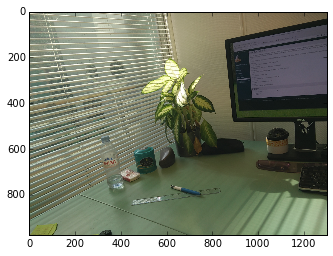

In [8]:
image2 =fabio.open("IMG_20161103_114433.tiff").data
imshow(image2)

keypoints2 = sift_ocl(image2)

Use MatchPlan to find the offset between the two images:

In [9]:
mp = sift.MatchPlan()
match = mp(keypoints, keypoints2)
print("Number of Keypoints with for image 1 : %i" % keypoints.size)
print("For image 2 : %i" % keypoints2.size)
print("Matching keypoints: %i" % match.shape[0])

from numpy import median
print("Measured offsets dx: %.3f, dy: %.3f" %
      (median(match[:,1].x - match[:,0].x), median(match[:,1].y-match[:,0].y)))

Number of Keypoints with for image 1 : 1159
For image 2 : 1261
Matching keypoints: 230
Measured offsets dx: 16.440, dy: 12.569


/usr/lib/python3/dist-packages/pyopencl/__init__.py:61: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


# Image alignement


Align image2 with image1, using a translation and a rotation:

/usr/lib/python3/dist-packages/pyopencl/__init__.py:61: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


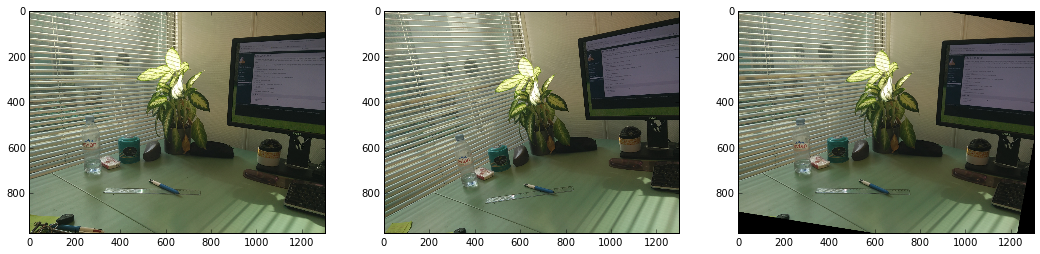

In [10]:
sa = sift.LinearAlign(image1)
image2_aligned = sa.align(image2)

figure(figsize=(18,5))
subplot(1,3,1)
imshow(image1)
subplot(1,3,2)
imshow(image2)
subplot(1,3,3)
imshow(image2_aligned)